In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, RepeatedKFold, GridSearchCV
from sklearn.preprocessing import RobustScaler,  
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [2]:
df = pd.read_csv("./data_baru/new_data.csv")
df

,Unnamed: 0,net_income,loan_amount,avg_amounts_previous_bills,avg_previous_payment,amount_of_late,late_payment_amount,credit_score,arrears_amounts,aging,employment_type,loss_reverse
0,0,15500000.0,1.562500e+07,29500000.0,24350000.0,2.0,1.0,670.0,0.0,DPK,Retired,0.000000e+00
1,1,17500000.0,1.770833e+07,3000000.0,1600000.0,31.0,3.0,402.0,1.0,DPK,Full-time,1.770833e+07
2,2,17500000.0,1.483333e+07,13500000.0,9050000.0,0.0,0.0,505.0,0.0,Lancar,Full-time,0.000000e+00
3,3,15500000.0,1.529167e+07,10500000.0,8350000.0,64.0,5.0,508.0,1.0,DPK,Retired,1.529167e+07
4,4,8700000.0,1.404167e+07,6500000.0,5750000.0,14.0,2.0,371.0,0.0,DPK,Contract,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,15500000.0,2.200000e+07,22000000.0,12900000.0,106.0,7.0,272.0,2.0,Kurang lancar,Retired,4.400000e+07
4996,4996,19000000.0,1.275000e+07,2000000.0,1600000.0,25.0,1.0,464.0,1.0,DPK,Full-time,1.275000e+07
4997,4997,12700000.0,1.537500e+07,10500000.0,10050000.0,53.0,4.0,369.0,1.0,DPK,Contract,1.537500e+07
4998,4998,13700000.0,1.475000e+07,8000000.0,4800000.0,27.0,1.0,266.0,1.0,DPK,Contract,1.475000e+07


In [3]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   net_income                  5000 non-null   float64
 1   loan_amount                 5000 non-null   float64
 2   avg_amounts_previous_bills  5000 non-null   float64
 3   avg_previous_payment        5000 non-null   float64
 4   amount_of_late              5000 non-null   float64
 5   late_payment_amount         5000 non-null   float64
 6   credit_score                5000 non-null   float64
 7   arrears_amounts             5000 non-null   float64
 8   aging                       5000 non-null   object 
 9   employment_type             5000 non-null   object 
 10  loss_reverse                5000 non-null   float64
dtypes: float64(9), object(2)
memory usage: 429.8+ KB


In [5]:
for i in df.columns:
    if df[i].dtype == "object":
        df[i] = df[i].astype("category")
        


In [6]:
aging = {"Lancar": 0, "DPK": 1, "Kurang lancar": 2, "Diragukan": 3, "Macet": 4}
employment_type = {"Not-employed": 0, "Self-employed": 1, "Internship": 2, "Part-time": 3, "Contract": 4, "Full-time": 5, "Retired": 6}
columns = {"aging" : aging, "employment_type": employment_type}

for i in df.columns:
    if df[i].dtype == "category" or df[i].dtype == "object":
        df[i] = [columns[i][j] for j in df[i]]

scaler = RobustScaler().fit(df[[i for i in df.columns if i not in columns]])
df2 = pd.DataFrame(scaler.transform(df[[i for i in df.columns if i not in columns]]), columns=df[[i for i in df.columns if i not in columns]].columns)
for i in columns:
    df2[i] = df[i]
df2.head(5)

,net_income,loan_amount,avg_amounts_previous_bills,avg_previous_payment,amount_of_late,late_payment_amount,credit_score,arrears_amounts,loss_reverse,aging,employment_type
0,0.000000,0.190476,1.24,1.431472,-0.800000,-0.6,1.589041,-1.0,-0.928218,1,6
1,0.266667,0.984127,-0.88,-0.878173,-0.413333,-0.2,0.365297,0.0,0.123762,1,5
2,0.266667,-0.111111,-0.04,-0.121827,-0.826667,-0.8,0.835616,-1.0,-0.928218,0,5
3,0.000000,0.063492,-0.28,-0.192893,0.026667,0.2,0.849315,0.0,-0.019802,1,6
4,-0.906667,-0.412698,-0.60,-0.456853,-0.640000,-0.4,0.223744,-1.0,-0.928218,1,4


In [7]:
X = df2.drop("loss_reverse", axis=1)
y = df2["loss_reverse"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4000, 10), (1000, 10), (4000,), (1000,))

In [8]:
model = BaggingRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [9]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = mse ** (1/2)
r_square = r2_score(y_test, y_pred)

print(f"""
      Mean Squared Errror : {mse:.2f}
      Mean Absolute Error : {mae:.2f}
      Mean Absolute Percentage Error : {mape:.2f}
      Root Mean Squared Error : {mape:.2f}
      R_Squared : {r_square:.2f}
      """)


      Mean Squared Errror : 0.00
      Mean Absolute Error : 0.01
      Mean Absolute Percentage Error : 0.01
      Root Mean Squared Error : 0.01
      R_Squared : 1.00
      


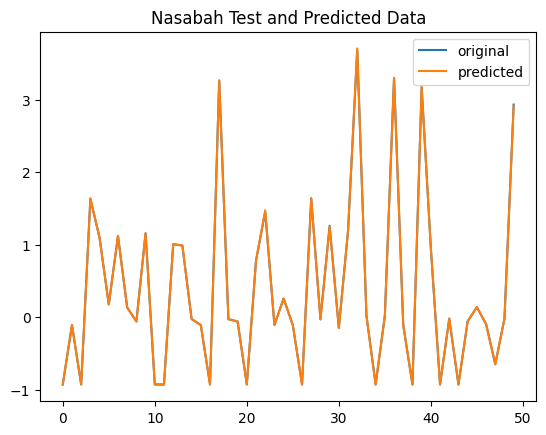

In [10]:
x_ax = range(len(y_test[:50]))
plt.plot(x_ax, y_test[:50], label="original")
plt.plot(x_ax, y_pred[:50], label="predicted")
plt.title("Nasabah Test and Predicted Data")
plt.legend()
plt.show()

In [11]:
y.describe()

count    5000.000000
mean        0.339512
std         1.081871
min        -0.928218
25%        -0.121287
50%         0.000000
75%         0.878713
max         9.678218
Name: loss_reverse, dtype: float64

In [15]:
df2

,net_income,loan_amount,avg_amounts_previous_bills,avg_previous_payment,amount_of_late,late_payment_amount,credit_score,arrears_amounts,loss_reverse,aging,employment_type
0,0.000000,0.190476,1.24,1.431472,-0.800000,-0.6,1.589041,-1.0,-0.928218,1,6
1,0.266667,0.984127,-0.88,-0.878173,-0.413333,-0.2,0.365297,0.0,0.123762,1,5
2,0.266667,-0.111111,-0.04,-0.121827,-0.826667,-0.8,0.835616,-1.0,-0.928218,0,5
3,0.000000,0.063492,-0.28,-0.192893,0.026667,0.2,0.849315,0.0,-0.019802,1,6
4,-0.906667,-0.412698,-0.60,-0.456853,-0.640000,-0.4,0.223744,-1.0,-0.928218,1,4
...,...,...,...,...,...,...,...,...,...,...,...
4995,0.000000,2.619048,0.64,0.269036,0.586667,0.6,-0.228311,1.0,1.685644,2,6
4996,0.466667,-0.904762,-0.96,-0.878173,-0.493333,-0.6,0.648402,0.0,-0.170792,1,5
4997,-0.373333,0.095238,-0.28,-0.020305,-0.120000,0.0,0.214612,0.0,-0.014851,1,4
4998,-0.240000,-0.142857,-0.48,-0.553299,-0.466667,-0.6,-0.255708,0.0,-0.051980,1,4
